# Changing parameter values

This notebook will cover:
* How to change dimensional and non-dimensional parameter values
* How to assign new parameter sets to existing models
* How to carry out parameter sweeps and compute stress-strain curves

## Overview of approach

Is it common to use modelling to predict the response of a material over a range of parameters.  In `ucompress.py`, models consist of symbolic (mathematically exact) expressions.  Parameter sets are then substituted into these symbolic expressions and the results are converted into NumPy functions.  The NumPy functions are called when simulating the model.  

Calculating the symbolic representation of a model ("building" the model) can be slow.  Therefore, `ucompress.py` separates the processes of building the symbolic model and building NumPy expressions via substitution of parameter values.  Changing the parameters in a model generally consists of two steps: updating the parameter object, and then assigning these to a model.


## Example 1 - Changing the Poisson's ratio

In this example, we showcase how to change one of the parameters in an existing parameter set.  We focus on changing the Poisson's ratio of the matrix.  However, the same process can be used to change any other parameter.

To get started, we load the parameter set of a standard neo-Hookean material and we print the value of the Poisson's ratio:

In [1]:
import ucompress as uc
import matplotlib.pyplot as plt
import numpy as np

pars = uc.parameters.example_parameters.NeoHookean(nondim = False)
print(f'The original Poisson\'s ratio is {pars.physical["nu_m"]}')

The original Poisson's ratio is 0


To change the value to $\nu_m = 0.3$, we use the `update` method, which requires two arguments: (i) a string corresponding to the parameter to be updated and (ii) the new parameter value.

In [2]:
pars.update('nu_m', 0.3)
print(f'The new Poisson\'s ratio is {pars.physical["nu_m"]}')

The new Poisson's ratio is 0.3


Any parameter that exists in the parameters object can be changed in this way.  To see a list of these parameters, type `print(pars)`.  The rest of the model can be built in the usual way:

In [3]:
# Define the parts of the model
mech = uc.mechanics.NeoHookean()
perm = uc.permeability.Constant()

# Build the model (which also assigns the parameter values)
model = uc.base_models.Poroelastic(mech, perm, pars)

# Compute the instantaneous response of a displacement-controlled compression
problem = uc.experiments.DisplacementControlled(model, pars)
sol = problem.initial_response()

print(f'The instantaneous force is {sol.F:.2} N')

The instantaneous force is -5.3 N


Now we'll change the Poisson's ratio again and re-compute the instantaneous force.  The first thing we do is update the value of the Poisson's ratio:

In [4]:
pars.update('nu_m', 0.45)
print(f'The new Poisson\'s ratio is {pars.physical["nu_m"]}')

The new Poisson's ratio is 0.45


The next step is to assign the new parameter set to the existing model using the `assign` method.

In [5]:
model.assign(pars)

Now we create a new displacement-controlled experiment and solve:

In [6]:
problem = uc.experiments.DisplacementControlled(model, pars)
sol = problem.initial_response()

print(f'The instantaneous force is {sol.F:.2} N')

The instantaneous force is -4.7 N


## Example 2 - Changing the applied force many times

In this example, we want to compute the equilibrium response across a range of applied forces.  This can be done using a for loop and using the `update` and `assign` methods from Example 1.  Since the permeability is not needed when computing the equilibrium response, we do not need to define a model for it. Instead, we can assign the `None` keyword to the `perm` variable we usually use for the permeability model.

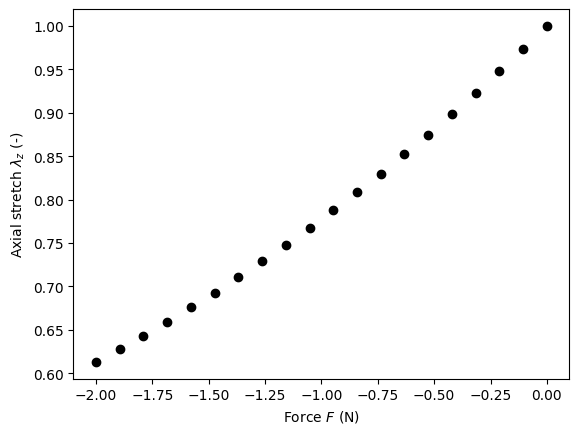

In [7]:
# Define the forces
forces = np.linspace(0, -2, 20)

# Define the model
pars = uc.parameters.example_parameters.NeoHookean(nondim = False)
mech = uc.mechanics.NeoHookean()
perm = None

# Build the model w/ default parameters to be changed in the loop
model = uc.base_models.Poroelastic(mech, perm, pars)

for F in forces:

    # Update parameter values
    pars.update('F', F)

    # Assign new parameters to model
    model.assign(pars)

    # Define experiment and solve
    problem = uc.experiments.ForceControlled(model, pars)
    sol = problem.steady_response()

    plt.plot(F, sol.lam_z, 'ko')


plt.xlabel('Force $F$ (N)')
plt.ylabel(r'Axial stretch $\lambda_z$ (-)')
plt.show()

## Example 3 - Changing parameters in a non-dimensional model

In this example, we will look at how the Young's modulus of the neo-Hookean matrix impacts the time-dependent response of a sample under displacement-controlled loading.  Non-dimensional parameter values will be used in the simulation.  

We first define the model:

In [8]:
# Define the parts of the model
pars = uc.parameters.example_parameters.NeoHookean(nondim = True)
mech = uc.mechanics.NeoHookean()
perm = uc.permeability.Constant()

# Build the model
model = uc.base_models.Poroelastic(mech, perm, pars)

The `update` and `assign` methods can still be used.  However, when using the `update` method, the new **dimensional** value of the parameter should passed as an argument.  The non-dimensionalisation of the new parameter set happens behind the scenes.  Afterwards, the `assign` method is used to substitute the updated parameter values, which will be non-dimensional, into the model.

In the code below, a for loop is used to simulate the model over three different calues of the Young's modulus:

--------------------------------
Transient step
Solver converged
Average number of Newton iterations per time step: 2.1
--------------------------------
Transient step
Solver converged
Average number of Newton iterations per time step: 2.1
--------------------------------
Transient step
Solver converged
Average number of Newton iterations per time step: 2.1


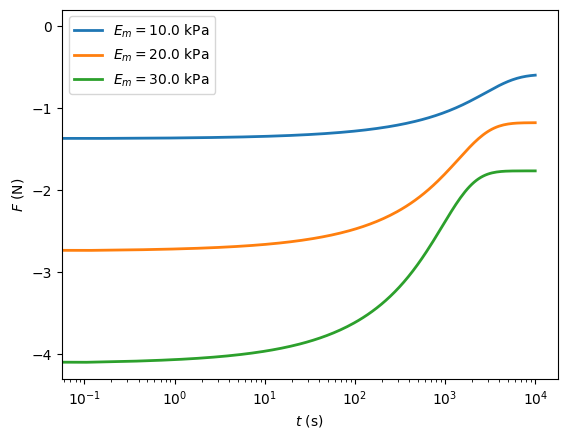

In [9]:
# loop over Young's modulus values (dimensional values)
for E_m in [1e4, 2e4, 3e4]:

    # update parameter set with new dimensional values
    pars.update('E_m', E_m)

    # assign updated parameters to the model
    model.assign(pars)

    # create an experiment and solve
    problem = uc.experiments.DisplacementControlled(model, pars)
    sol = problem.transient_response()

    # re-dimensionalise the solution
    sol.redimensionalise(pars)
    
    # plot
    plt.semilogx(sol.t, sol.F, lw = 2, label = f'$E_m = {E_m/1e3}$ kPa')

plt.xlabel('$t$ (s)')
plt.ylabel('$F$ (N)')
plt.legend()
plt.show()